__Исследование взаимосвязи погоды и ДТП в городе Москва.__
В данном исследовании рассматривается вопрос взаимосвязи ДТП и погодных характеристик для города Москвы за 2015-2021 года. В качестве исходных данных для ДТП взяты открытые данные сайтов dtp-stat.ru, для погоды - открытые данные сайта rp5.ru для станции метеонаблюдения Балчуг (центр Москвы). Итогом проекта станет динамический дашборд, позволяющий оценить изменение вероятности ДТП для выбранных категорий условий.

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
#import seaborn as sns
#import matplotlib.pyplot as plt
import numpy as np
#import json
#from io import BytesIO
#import requests
#Изменение ограничений на длину вывода информации
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 50)
#import warnings
#warnings.filterwarnings('ignore') #Много предупреждений о копировании датасетов через .loc, отключил
import geopandas as gpd
from pymystem3 import Mystem
lemm = Mystem()
from collections import Counter

расшифровка столбцов:
- 'Местное время в Москве (центр, Балчуг)',
-  'T' - 'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли'
- 'Po' - Атмосферное давление на уровне станции (миллиметры ртутного столба)- 
-  'P' - Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)
-  'Pa' - Барическая тенденция: изменение атмосферного давления за последние три часа (миллиметры ртутного столба)'
-  'U' - Относительная влажность (%) на высоте 2 метра над поверхностью земли
-  'DD'- Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период, непосредственно предшествовавший сроку наблюдения'
-  'Ff' - Cкорость ветра на высоте 10-12 метров над земной поверхностью, осредненная за 10-минутный период, непосредственно предшествовавший сроку наблюдения (метры в секунду)
-  'ff10'- 'Максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за 10-минутный период, непосредственно предшествующий сроку наблюдения (метры в секунду)
-  'ff3'- Максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за период между сроками (метры в секунду)
-  'N'- Общая облачность
-  'WW' - Текущая погода, сообщаемая с метеорологической станции
-  'W1'- Прошедшая погода между сроками наблюдения 1
-  'W2'- Прошедшая погода между сроками наблюдения 2
-  'Tn'- Минимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
-  'Tx' - Максимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)
-  'Cl' - Слоисто-кучевые, слоистые, кучевые и кучево-дождевые облака
-  'Nh' - Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm
-  'H' - Высота основания самых низких облаков (м)
-  'Cm'- Высококучевые, высокослоистые и слоисто-дождевые облака
-  'Ch' - Перистые, перисто-кучевые и перисто-слоистые облака
-  'VV'- Горизонтальная дальность видимости (км)
-  'Td' - Температура точки росы на высоте 2 метра над поверхностью земли (градусы Цельсия)
-  'RRR' - Количество выпавших осадков (миллиметры)
-  'tR' -Период времени, за который накоплено указанное количество осадков (часы)
-  'E'- Состояние поверхности почвы без снега или измеримого ледяного покрова,
-  'Tg' -Минимальная температура поверхности почвы за ночь. (градусы Цельсия),
-  "E'" -Состояние поверхности почвы со снегом или измеримым ледяным покровом,
-  'sss' - Высота снежного покрова (см) - накопительно

Сложность 1: определить, какие из множества значений действительно влияют на целевой параметр

In [2]:
weather = pd.read_csv('BALCHUG.01.01.2015.04.01.2022.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=False)
weather.rename(columns={'Местное время в Москве (центр, Балчуг)':'время'}, inplace=True)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17142 entries, 0 to 17141
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   время   17142 non-null  object 
 1   T       17140 non-null  float64
 2   Po      17142 non-null  float64
 3   P       17142 non-null  float64
 4   Pa      2463 non-null   float64
 5   U       17140 non-null  float64
 6   DD      17140 non-null  object 
 7   Ff      17141 non-null  float64
 8   ff10    71 non-null     float64
 9   ff3     562 non-null    float64
 10  N       17128 non-null  object 
 11  WW      17142 non-null  object 
 12  W1      4960 non-null   object 
 13  W2      4960 non-null   object 
 14  Tn      4181 non-null   float64
 15  Tx      2149 non-null   float64
 16  Cl      14626 non-null  object 
 17  Nh      14626 non-null  object 
 18  H       12659 non-null  object 
 19  Cm      9474 non-null   object 
 20  Ch      6356 non-null   object 
 21  VV      14893 non-null  float64
 22

In [3]:
weather.head(2)

,время,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,04.01.2022 15:00,-6.3,741.1,752.9,NaN,77.0,"Штиль, безветрие",0.0,NaN,NaN,100%.,,NaN,NaN,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,1000-1500,"Высококучевые просвечивающие, полосами, либо о...",NaN,10.0,-9.7,NaN,NaN,NaN,NaN,NaN,NaN
1,04.01.2022 12:00,-7.0,740.8,752.7,NaN,83.0,"Ветер, дующий с востоко-юго-востока",1.0,NaN,NaN,100%.,,NaN,NaN,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,10.0,-9.5,NaN,NaN,NaN,NaN,NaN,NaN


Изучим json массив. Для начала прочитаем его в датафрейм data

In [4]:
data = pd.read_json('moskva.json')
data.head()


,type,features
0,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
1,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
2,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
3,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."
4,FeatureCollection,"{'type': 'Feature', 'geometry': {'type': 'Poin..."


In [5]:
data = pd.json_normalize(data['features'])

In [6]:
data.head()

,type,geometry.type,geometry.coordinates,properties.id,properties.tags,properties.light,properties.point.lat,properties.point.long,properties.nearby,properties.region,properties.scheme,properties.address,properties.weather,properties.category,properties.datetime,properties.severity,properties.vehicles,properties.dead_count,properties.participants,properties.injured_count,properties.parent_region,properties.road_conditions,properties.participants_count,properties.participant_categories
0,Feature,Point,"[37.770245, 55.667499]",2575117,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",55.667499,37.770245,[Автостоянка (не отделённая от проезжей части)...,Люблино,910,"г Москва, ул Верхние Поля, 39",[Ясно],Наезд на стоящее ТС,2021-05-21 00:35:00,Легкий,"[{'year': 1993, 'brand': 'TOYOTA', 'color': 'С...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",2,Москва,[Сухое],3,"[Пешеходы, Все участники]"
1,Feature,Point,"[37.553995, 55.669411]",2575131,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",55.669411,37.553995,[Крупный торговый объект (являющийся объектом ...,Черемушки,960,"г Москва, ул Профсоюзная, 56",[Ясно],Падение пассажира,2021-05-14 22:30:00,Легкий,"[{'year': 2018, 'brand': 'FORD', 'color': 'Мно...",0,[],1,Москва,[Сухое],2,[Все участники]
2,Feature,Point,"[37.577877, 55.752538]",2575134,"[Дорожно-транспортные происшествия, ДТП и пост...",Светлое время суток,55.752538,37.577877,"[Многоквартирные жилые дома, Зоны отдыха, Адми...",Арбат,820,"г Москва, ул Новый Арбат, 27","[Пасмурно, Дождь]",Наезд на пешехода,2021-02-10 14:40:00,Легкий,"[{'year': 2019, 'brand': 'MERCEDES', 'color': ...",0,"[{'role': 'Пешеход', 'gender': 'Мужской', 'vio...",1,Москва,[Мокрое],2,"[Дети, Пешеходы, Все участники]"
3,Feature,Point,"[37.322574, 55.802463]",2575136,[Дорожно-транспортные происшествия],Светлое время суток,55.802463,37.322574,"[Многоквартирные жилые дома, АЗС, Нерегулируем...",Спецтрассы,070,"г Москва, А-109 А-109 Ильинское шоссе, 3 км",[Пасмурно],Столкновение,2021-04-29 07:45:00,Легкий,"[{'year': 2018, 'brand': 'ГАЗ', 'color': 'Белы...",0,[],1,Москва,[Сухое],4,[Все участники]
4,Feature,Point,"[37.347625, 55.635167]",2599457,[Дорожно-транспортные происшествия],Светлое время суток,55.635167,37.347625,"[Многоквартирные жилые дома, АЗС, Остановка об...",Ново-Переделкино,None,"г Москва, ш Боровское, 52",[Ясно],Опрокидывание,2021-07-18 15:09:00,Легкий,[],0,"[{'role': 'Водитель', 'gender': None, 'violati...",1,Москва,[Сухое],1,[Все участники]


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62568 entries, 0 to 62567
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   type                               62568 non-null  object 
 1   geometry.type                      62568 non-null  object 
 2   geometry.coordinates               62568 non-null  object 
 3   properties.id                      62568 non-null  int64  
 4   properties.tags                    62568 non-null  object 
 5   properties.light                   62568 non-null  object 
 6   properties.point.lat               62485 non-null  float64
 7   properties.point.long              62485 non-null  float64
 8   properties.nearby                  62568 non-null  object 
 9   properties.region                  62568 non-null  object 
 10  properties.scheme                  59137 non-null  object 
 11  properties.address                 58761 non-null  obj

Можем удалить излишние столбцы: 'type', 'geometry.type', 'properties.point.lat','properties.point.long'

In [8]:
data.drop(axis='columns', labels={'type'}, inplace=True) #, 'geometry.type', 'properties.point.lat','properties.point.long'}, inplace=True)

In [9]:
dtp_vehicles = pd.json_normalize(data.loc[:,'properties.vehicles'])
dtp_vehicles['properties.id'] = data.loc[:,'properties.id']


In [10]:
dtp_vehicles['car_count'] = dtp_vehicles.loc[:].count(axis=1)-2 # добавим столбец с количеством участвующих авто
dtp_vehicles.head()
dtp_vehicles[0][0]['participants']

[{'role': 'Водитель',
  'gender': 'Мужской',
  'violations': ['Несоответствие скорости конкретным условиям движения',
   'Отказ водителя от прохождения медицинского освидетельствования на состояние опьянения'],
  'health_status': 'Не пострадал',
  'years_of_driving_experience': 2}]

In [11]:
dtp_part = pd.json_normalize(data.loc[:,'properties.participants'])
dtp_part['properties.id'] = data.loc[:,'properties.id'] #Добавим ключ 
dtp_part['part_count'] = dtp_part.loc[:].count(axis=1)-1 # Добавим столбец с количеством участвующих в дтп людей
dtp_part.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,properties.id,part_count
0,"{'role': 'Пешеход', 'gender': 'Женский', 'viol...","{'role': 'Пешеход, перед ДТП находившийся в (н...",None,None,None,None,None,None,None,None,None,None,None,2575117,2
1,None,None,None,None,None,None,None,None,None,None,None,None,None,2575131,0
2,"{'role': 'Пешеход', 'gender': 'Мужской', 'viol...",None,None,None,None,None,None,None,None,None,None,None,None,2575134,1
3,None,None,None,None,None,None,None,None,None,None,None,None,None,2575136,0
4,"{'role': 'Водитель', 'gender': None, 'violatio...",None,None,None,None,None,None,None,None,None,None,None,None,2599457,1


## Добавление информации о трафике в Москве

Данные о часовой загрузке дорог по дням недели выгружены с tomtom.com.

In [12]:
traffic_2017=pd.read_excel('moscow_traffic.xlsx', sheet_name='2017')
traffic_2018=pd.read_excel('moscow_traffic.xlsx', sheet_name='2018')
traffic_2019=pd.read_excel('moscow_traffic.xlsx', sheet_name='2019')
traffic_2020=pd.read_excel('moscow_traffic.xlsx', sheet_name='2020')
traffic_2021=pd.read_excel('moscow_traffic.xlsx', sheet_name='2021')
traffic_2017

,Unnamed: 0,6,0,1,2,3,4,5
0,0,0.05,0.02,0.02,0.03,0.04,0.05,0.09
1,1,0.02,0.00,0.00,0.00,0.00,0.01,0.04
2,2,0.01,0.00,0.00,0.00,0.00,0.00,0.02
3,3,0.00,0.00,0.00,0.00,0.00,0.00,0.01
4,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,5,0.00,0.00,0.01,0.01,0.00,0.00,0.00
6,6,0.00,0.25,0.24,0.23,0.22,0.20,0.03
7,7,0.00,0.65,0.62,0.60,0.57,0.53,0.08
8,8,0.03,0.90,0.91,0.86,0.83,0.75,0.15
9,9,0.08,0.76,0.86,0.81,0.79,0.68,0.23


In [13]:
#data.loc[data['properties.datetime'].dt.year==2017]['properties.datetime'].dt.dayofweek
#Преобразуем время в формат datetime
data['properties.datetime'] = pd.to_datetime(arg=data['properties.datetime'], format='%Y-%m-%d %H:%M:%S') #2021-05-21 00:35:00

data['year'] = data['properties.datetime'].dt.year
data.loc[data['year']==2017, 'traffic'] = data.loc[data['year']==2017]['properties.datetime'].apply(lambda x: traffic_2017[x.dayofweek][x.hour])
data.loc[data['year']==2018, 'traffic'] = data.loc[data['year']==2018]['properties.datetime'].apply(lambda x: traffic_2018[x.dayofweek][x.hour])
data.loc[data['year']==2019, 'traffic'] = data.loc[data['year']==2019]['properties.datetime'].apply(lambda x: traffic_2019[x.dayofweek][x.hour])
data.loc[data['year']==2020, 'traffic'] = data.loc[data['year']==2020]['properties.datetime'].apply(lambda x: traffic_2020[x.dayofweek][x.hour])
data.loc[data['year']==2021, 'traffic'] = data.loc[data['year']==2021]['properties.datetime'].apply(lambda x: traffic_2021[x.dayofweek][x.hour])

data.groupby(data['properties.datetime'].dt.year).mean()['traffic']

properties.datetime
2015         NaN
2016         NaN
2017    0.541103
2018    0.539212
2019    0.566971
2020    0.518129
2021    0.547004
Name: traffic, dtype: float64

В 2020 году ДТП происходили при меньшей загруженности на дорогах. Для 2015 и 2016 года заполним данные средними значениями 2017-2021 года. Они не будут абсолютно точными в историческом смысле, но напряженность движения по дням недели и часам суток передадут с определенной достоверностью

In [14]:
traffic_2015 = (traffic_2017+traffic_2018+traffic_2019+traffic_2020+traffic_2021)/5
traffic_2016 = (traffic_2017+traffic_2018+traffic_2019+traffic_2020+traffic_2021)/5

data.loc[data['year']==2015, 'traffic'] = data.loc[data['year']==2015]['properties.datetime'].apply(lambda x: traffic_2015[x.dayofweek][x.hour])
data.loc[data['year']==2016, 'traffic'] = data.loc[data['year']==2016]['properties.datetime'].apply(lambda x: traffic_2016[x.dayofweek][x.hour])

data.groupby(data['properties.datetime'].dt.year).mean()['traffic']

properties.datetime
2015    0.530942
2016    0.531776
2017    0.541103
2018    0.539212
2019    0.566971
2020    0.518129
2021    0.547004
Name: traffic, dtype: float64

## Преобразование категорий
Для корректной связки данных о погоде и данных о дтп необходимо преобразовать стобцы с информацией о дате и времени. И так как данные о погоде идут с 3-х часовым лагом (кстати, проверим это)

In [15]:
weather['время'] = pd.to_datetime(weather['время'], format='%d.%m.%Y %H:%M')
weather.head(1)

,время,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,2022-01-04 15:00:00,-6.3,741.1,752.9,NaN,77.0,"Штиль, безветрие",0.0,NaN,NaN,100%.,,NaN,NaN,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",50%.,1000-1500,"Высококучевые просвечивающие, полосами, либо о...",NaN,10.0,-9.7,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
set(weather['время'].dt.hour) 

{0, 3, 6, 9, 12, 15, 18, 21}

Действительно, во всем датасете временной интервал погоды равен трем часам, от 0 до 21 часа. Следовательно, нам необходимо все временные отметки данных о ДТП округлить к ближайшему значению.

In [17]:
data['properties.datetime'] = data['properties.datetime'].dt.round(freq='3H')

In [18]:
weather.loc[weather.sort_values('время', ascending=True
                               )['время'
                                ].diff(
                                ).apply(lambda x: x/pd.Timedelta('1 hour'))==6
      ].head()#groupby(weather['время'
               #        ].dt.hour
               #).count()


,время,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
34,2021-12-31 09:00:00,-5.3,747.5,759.4,NaN,87.0,"Ветер, дующий с юго-юго-востока",1.0,NaN,NaN,100%.,Дымка.,Облака покрывали более половины неба в течение...,Облака покрывали более половины неба в течение...,-6.7,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,4.0,-7.2,Осадков нет,12.0,NaN,NaN,Ровный слой сухого рассыпчатого снега покрывае...,25.0
90,2021-12-24 06:00:00,-10.4,744.4,756.6,NaN,78.0,"Ветер, дующий с юго-юго-запада",1.0,NaN,NaN,100%.,,NaN,NaN,-11.2,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",100%.,"2500 или более, или облаков нет.",Высокослоистые непросвечивающие или слоисто-до...,NaN,10.0,-13.6,Осадков нет,12.0,NaN,NaN,NaN,NaN
120,2021-12-20 09:00:00,-7.4,732.7,744.6,NaN,86.0,"Ветер, дующий с северо-запада",3.0,NaN,NaN,100%.,Снег непрерывный слабый в срок наблюдения.,Снег и/или другие виды твердых осадков,Облака покрывали более половины неба в течение...,-7.4,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",100%.,300-600,Высокослоистые непросвечивающие или слоисто-до...,NaN,4.0,-9.4,2.0,12.0,NaN,NaN,Ровный слой сухого рассыпчатого снега покрывае...,24.0
303,2021-11-27 09:00:00,3.2,745.1,756.6,NaN,79.0,"Ветер, дующий с юго-юго-востока",1.0,NaN,NaN,100%.,,NaN,NaN,2.9,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,10.0,-0.1,Осадков нет,12.0,NaN,NaN,NaN,NaN
534,2021-10-29 09:00:00,7.3,757.6,769.1,NaN,70.0,"Ветер, дующий с юго-запада",1.0,NaN,NaN,100%.,,NaN,NaN,6.9,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,600-1000,NaN,NaN,10.0,2.2,Осадков нет,12.0,Поверхность почвы влажная.,5.0,NaN,NaN


Определим, есть ли пропуски в данных о погоде, какой они длительности и сколько их

In [19]:
weather.sort_values('время', ascending=True
      ).groupby(weather.sort_values('время', ascending=True
                       )['время'
                       ].diff()
               ).count(
       )['время'
        ].rename(lambda x: x/pd.Timedelta('1 hour')
        ).reset_index(name='Количество диапазонов')


,время,Количество диапазонов
0,3.0,16951
1,6.0,174
2,9.0,5
3,12.0,2
4,15.0,1
5,21.0,1
6,27.0,6
7,9291.0,1


Отсутствующие значения погоды возьмем из набора данных погоды с ВДНХ

In [20]:
weather_vdnh = pd.read_csv('VDNH.01.01.2015.04.01.2022.1.0.0.ru.utf8.00000000.csv', skiprows=6, sep=';', index_col=False)
weather_vdnh.rename(columns={'Местное время в Москве (ВДНХ)':'время'}, inplace=True)
weather_vdnh['время'] = pd.to_datetime(weather_vdnh['время'], format='%d.%m.%Y %H:%M')
weather_vdnh['время'] = weather_vdnh['время'].dt.round(freq='3H') #Округлим временные отметки для их единообразия
weather_vdnh.head(1)


,время,T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,2022-01-04 21:00:00,-6.2,739.2,753.4,0.2,80.0,"Ветер, дующий с юга",1,NaN,NaN,100%.,Состояние неба в общем не изменилось.,Снег и/или другие виды твердых осадков,Облака покрывали более половины неба в течение...,NaN,-6.2,"Слоисто-кучевые, образовавшиеся не из кучевых.",100%.,1000-1500,NaN,NaN,13.0,-9.1,0.1,12.0,NaN,NaN,NaN,NaN


Добавим в weather данные с ВДНХ по отсутствующим пунктам.

In [21]:
weather = weather.append(weather_vdnh.loc[~weather_vdnh['время'].isin(weather['время'])], ignore_index=True)

In [22]:
weather.sort_values('время', ascending=True
      ).groupby(weather.sort_values('время', ascending=True
                       )['время'
                       ].diff()
               ).count(
       )['время'
        ].rename(lambda x: x/pd.Timedelta('1 hour')
        ).reset_index(name='Количество диапазонов')


,время,Количество диапазонов
0,3.0,20474
1,6.0,5
2,9.0,1


In [105]:
dtp_join['weather'] = dtp_join['weather'].apply(lambda x:' '.join(x))
dtp_join['road_conditions'] = dtp_join['road_conditions'].apply(lambda x:' '.join(x))

Оставшиеся отсутствующие значения можем проигнорировать, на общее качество данных они не повлияют. Можно приступать к объединению датафреймов

In [23]:
dtp_join = data.merge(weather, how='left', left_on='properties.datetime', right_on='время')
#Проверим, сколько пустых значений получилось в данных
dtp_join.loc[dtp_join['properties.datetime']!=dtp_join['время'], 'properties.datetime'].count()

11

Всего 11 ДТП остались без данных о погоде. Удалим их из датафрейма

In [24]:
dtp_join = dtp_join.loc[~dtp_join['время'].isna()]
#Проверим
dtp_join.loc[dtp_join['properties.datetime']!=dtp_join['время'], 'properties.datetime'].count()

0

In [25]:
dtp_join['RRR'] = pd.to_numeric(dtp_join['RRR'], errors='coerce')
dtp_join['sss'] = pd.to_numeric(dtp_join['sss'], errors='coerce')

In [26]:
dtp_join['VV'] = pd.to_numeric(dtp_join['VV'], errors='coerce')

In [27]:
dict = {'10%  или менее, но не 0':10,
 '100%.':100,
 '20–30%.':30,
 '40%.':40,
 '50%.':50,
 '60%.':60,
 '70 – 80%.':80,
 '90  или более, но не 100%':90,
 'Облаков нет.':0,
        'Небо не видно из-за тумана и/или других метеорологических явлений.':100,
       np.nan:None}
dtp_join['Nh'] = dtp_join['Nh'].apply(lambda x: dict[x])
dtp_join['N'] = dtp_join['N'].apply(lambda x: dict[x])


В колонке NN содержатся данные о погоде на момент наблюдения. Проверим количество имеющихся категорий.

In [28]:
dtp_join.groupby('WW').count()['properties.id'].sort_values(ascending=False)

WW
                                                                                            42818
Состояние неба в общем не изменилось.                                                        5035
Дымка.                                                                                       4016
Снег непрерывный слабый в срок наблюдения.                                                   2890
Дождь незамерзающий непрерывный слабый в срок наблюдения.                                    1992
                                                                                            ...  
Морось незамерзающая с перерывами слабая в срок наблюдения.                                     3
Состояние неба в общем не изменилось.  Максимальный диаметр градин составляет 12 мм.            3
Туман или ледяной туман, неба не видно, начался или усилился в течение последнего часа.         3
Дождь замерзающий слабый.  Диаметр отложения при гололеде составляет 1 мм.                      2
Дымка.  Диаметр о

42 тысячи записей без данных о погоде, и еще 56 категорий. Такое количество признаков избыточно. Попробуем использовать лемматизацию для обобщения категорий.

ww_dict = pd.DataFrame(columns=['ww', 'lemms', 'ww_id'])
ww_dict['ww'] = dtp_join['WW'].unique() #здесь не используем множества, так как 
#множество может вывести данные в произвольном порядке
ww_dict['lemms'] = ww_dict['ww'].apply(lambda x: lemm.lemmatize(x))
#выведем список наиболее часто встречающихся лемм.
#ww_dict['lemms'].str.join(' ').str.get_dummies(sep=' ').sum().sort_values(ascending=False)

Составим словарь сгруппированных описаний погодных явлений, которые нас интересуют

ww_dict['lemms'][2].index('дождь')

In [ ]:
#ww_dictionary = {

## Разведывательный анализ данных


Bad key text.latex.preview in file D:\Applications\Anaconda\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file D:\Applications\Anaconda\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file D:\Applications\Anaconda\envs\praktikum\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is save

<AxesSubplot:xlabel='properties.datetime'>

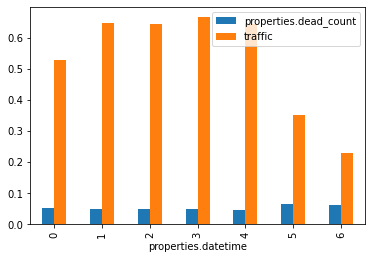

In [33]:
(dtp_join.groupby(dtp_join['properties.datetime'].dt.dayofweek).mean()
          [{'properties.dead_count', 'traffic'}]).plot(kind='bar') #Средний трафик и смертельность ДТП по дням недели

Точечное распределение смертей и трафика

<AxesSubplot:xlabel='traffic', ylabel='properties.dead_count'>

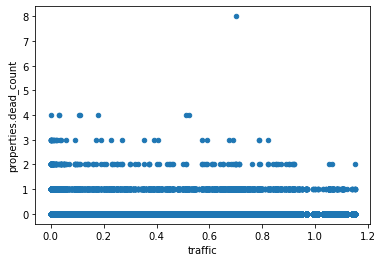

In [34]:
dtp_join[{'properties.dead_count', 'traffic'}].plot(kind='scatter', x='traffic', y='properties.dead_count') #Средний трафик и смертельность ДТП по дням недели


Количество ДТП по неделям года

<AxesSubplot:xlabel='week'>

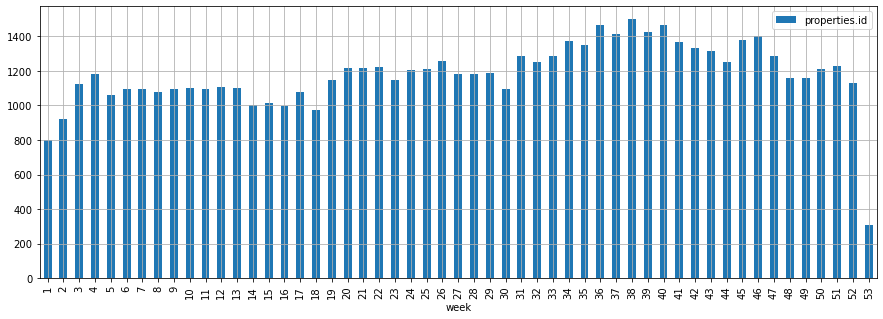

In [35]:
(dtp_join[dtp_join['properties.datetime'].dt.month>0]
 .groupby(dtp_join['properties.datetime'].dt.isocalendar().week)
 .count()[{'properties.id'}]
 .plot(kind='bar', figsize=(15,5), grid=True)
)

<AxesSubplot:xlabel='properties.point.lat', ylabel='properties.point.long'>

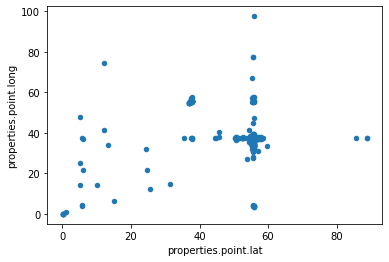

In [36]:
dtp_join.plot(kind='scatter', x='properties.point.lat', y='properties.point.long')


Координаты не соответсвуют реальному положению дел. При координатах Москвы 37,5:55,5 видно, что множество значений выбивается далеко за эти рамки. При координатах крайних точек ЦКАД:
Север: 56°19' 37°51'
Восток: 55°8' 38°58'
Юг: 55°32' 37°58'
Запад: 55°71' 36°85' 
Посмотрим, сколько значений с неверными координатами

<AxesSubplot:xlabel='properties.point.long', ylabel='properties.point.lat'>

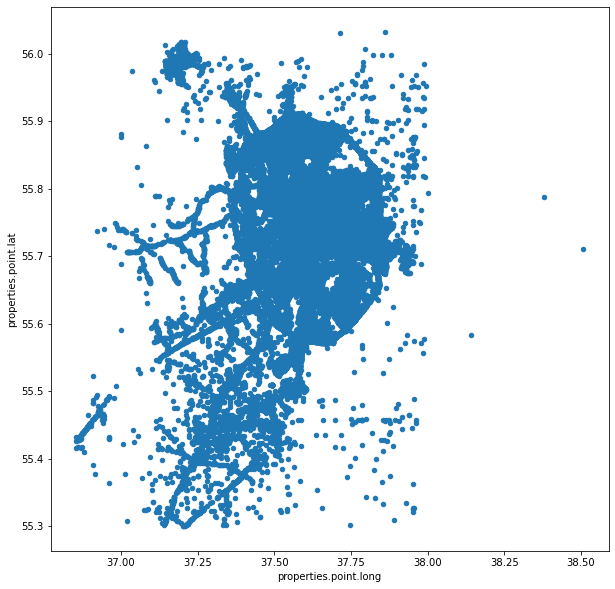

In [37]:
(dtp_join.query('55.3<`properties.point.lat`<56.19 and 38.58>`properties.point.long`>36.85')
 .plot(kind='scatter', y='properties.point.lat', x='properties.point.long', figsize=(10,10)))


Это распределение соответствует очертаниям Москвы, новой Москвы, Зеленограда, Люберец и Южных вылетных трасс. Восточнее 38 меридиана практически нет отметок ДТП, что странно. Подсчитаем количество геометок, выходящих за пределы этого квадрата.

In [38]:
(dtp_join.query('`properties.point.lat`>56.19 or `properties.point.lat`<55.3 or `properties.point.long`>38.58 or `properties.point.long`<36.85')['properties.id']
 .count())

1164

1164 отметки из 62 тысяч. Обнулим их координаты, чтобы не вносить искажения в дальнейшее ислледование при рассмотрении позиции. При необходимости, в последующем мы сможем определить эти координаты на основании указанных адресов ДТП.

In [39]:
dtp_join.loc[((dtp_join['properties.point.lat']>56.19)|(dtp_join['properties.point.lat']<55.3))
            |((dtp_join['properties.point.long']>38.58)|(dtp_join['properties.point.long']<36.85)), 'properties.point.lat'] = np.nan
dtp_join.loc[((dtp_join['properties.point.lat']>56.19)|(dtp_join['properties.point.lat']<55.3))
            |((dtp_join['properties.point.long']>38.58)|(dtp_join['properties.point.long']<36.85)), 'properties.point.long'] = np.nan

<AxesSubplot:xlabel='properties.point.long', ylabel='properties.point.lat'>

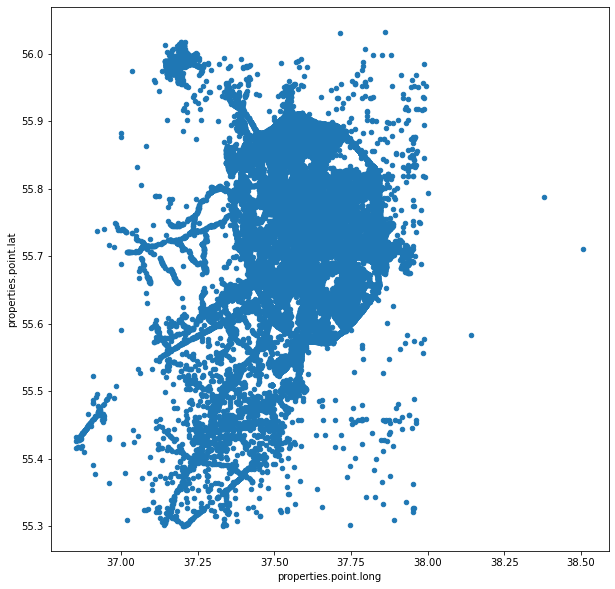

In [40]:
dtp_join.plot(kind='scatter', y='properties.point.lat', x='properties.point.long', figsize=(10,10))


array([[<AxesSubplot:title={'center':'properties.point.long'}>,
        <AxesSubplot:title={'center':'properties.point.lat'}>]],
      dtype=object)

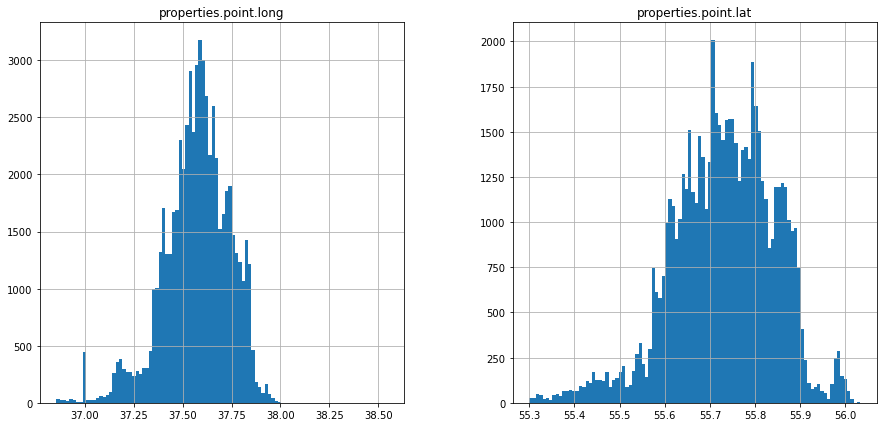

In [41]:
dtp_join[{'properties.point.lat', 'properties.point.long'}].hist(bins=100, figsize=(15,7))

Наблюдается аномальный всплеск значений на 37-м меридиане и действительно, после 38 меридиана ДТП пропадают.

In [42]:
dtp_join.query('`properties.point.long`==37')[{'properties.point.lat', 'properties.point.long'}].describe()

,properties.point.long,properties.point.lat
count,433.0,4.000000
mean,37.0,55.759775
std,0.0,0.144027
min,37.0,55.590833
25%,37.0,55.664583
50%,37.0,55.783133
75%,37.0,55.878325
max,37.0,55.882000


Из 433 геометок на долготы 37 градусов только 4 содержат значения, остальные пустые. Это уже вторая ошибка в данных, связанная с целым числом градусов долготы. Если вспомнить распределение координат до обнуления координат, то большая часть значений на графике была изображена в виде крестообразной отметки, т.е. у практически тысячи отметок были потеряны данные по одной из координат. Проверим, сколько еще есть значений, у которых одна из координат отсутствует.


In [43]:
(dtp_join.loc[(dtp_join['properties.point.lat'].isna()&
              ~dtp_join['properties.point.long'].isna())|
             (~dtp_join['properties.point.lat'].isna()&
              dtp_join['properties.point.long'].isna())]
 [{'properties.point.lat', 'properties.point.long'}])

,properties.point.long,properties.point.lat
137,37.000000,NaN
185,37.687500,NaN
214,37.000000,NaN
238,37.644900,NaN
673,37.155601,NaN
...,...,...
61741,37.000000,NaN
61866,37.962800,NaN
61936,37.153100,NaN
62225,37.075403,NaN


Еще 961 значение имеет только одну координату. Тоже обнулим их.

In [44]:
dtp_join.loc[(dtp_join['properties.point.lat'].isna()&
              ~dtp_join['properties.point.long'].isna())|
             (~dtp_join['properties.point.lat'].isna()&
              dtp_join['properties.point.long'].isna()), 'properties.point.lat'] = np.nan
dtp_join.loc[(dtp_join['properties.point.lat'].isna()&
              ~dtp_join['properties.point.long'].isna())|
             (~dtp_join['properties.point.lat'].isna()&
              dtp_join['properties.point.long'].isna()), 'properties.point.long'] = np.nan
(dtp_join.loc[(dtp_join['properties.point.lat'].isna()&
              ~dtp_join['properties.point.long'].isna())|
             (~dtp_join['properties.point.lat'].isna()&
              dtp_join['properties.point.long'].isna())]
 [{'properties.point.lat', 'properties.point.long'}]) #Проверим обнуление

,properties.point.long,properties.point.lat


In [45]:
dtp_join[{'properties.point.lat', 'properties.point.long'}].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62557 entries, 0 to 62567
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   properties.point.long  61311 non-null  float64
 1   properties.point.lat   61311 non-null  float64
dtypes: float64(2)
memory usage: 1.4 MB


Проверим распределение ДТП по координатам после очистки значений

array([[<AxesSubplot:title={'center':'properties.point.long'}>,
        <AxesSubplot:title={'center':'properties.point.lat'}>]],
      dtype=object)

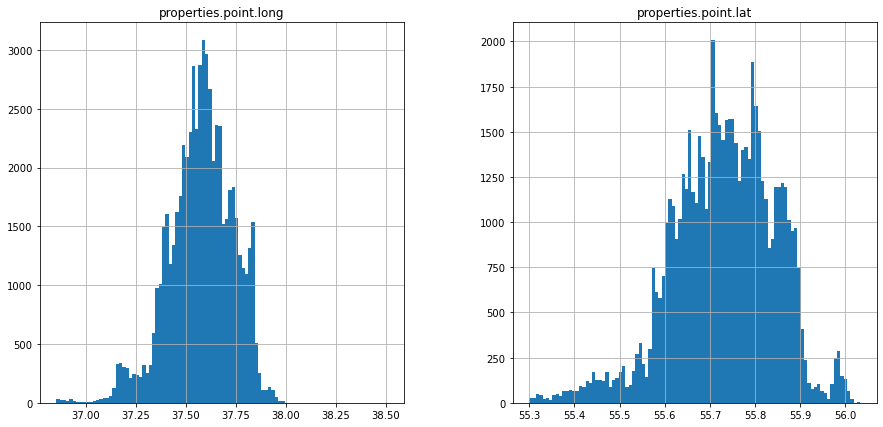

In [46]:
dtp_join[{'properties.point.lat', 'properties.point.long'}].hist(bins=100, figsize=(15,7))

Распределение приобрело более сглаженный вид.


In [47]:
dtp_join.describe()

,properties.id,properties.point.lat,properties.point.long,properties.dead_count,properties.injured_count,properties.participants_count,year,traffic,T,Po,P,Pa,U,Ff,ff10,ff3,N,Tn,Tx,Nh,VV,Td,RRR,tR,Tg,sss
count,6.255700e+04,61311.000000,61311.000000,62557.000000,62557.000000,62557.000000,62557.000000,62557.000000,62550.000000,62557.000000,62557.000000,18570.000000,62548.000000,62555.00000,316.000000,2669.000000,62514.000000,11482.000000,9841.000000,54316.000000,51585.000000,62552.000000,11680.000000,32761.0,4766.000000,2324.000000
mean,1.731460e+06,55.730151,37.577201,0.053295,1.141103,2.417619,2017.847387,0.539507,9.329325,749.873458,761.748765,-0.014168,65.670221,1.23608,10.708861,11.044586,75.076783,5.338155,11.730749,72.925105,9.053407,2.219328,2.763476,12.0,9.469576,19.427711
std,3.866550e+05,0.113833,0.159856,0.247059,0.625812,0.919160,1.992513,0.305162,10.560642,7.585411,7.647608,0.938282,20.043819,0.79518,1.025415,1.418407,35.439403,9.202349,11.140919,35.450484,2.357535,8.316423,4.386220,0.0,5.424578,14.690008
min,1.527476e+06,55.300000,36.852994,0.000000,0.000000,1.000000,2015.000000,0.000000,-27.300000,715.000000,726.000000,-5.100000,10.000000,0.00000,10.000000,10.000000,0.000000,-27.800000,-23.400000,0.000000,0.500000,-30.300000,0.100000,12.0,-4.000000,1.000000
25%,1.543115e+06,55.656521,37.482476,0.000000,1.000000,2.000000,2016.000000,0.280000,1.200000,745.000000,756.900000,-0.600000,50.000000,1.00000,10.000000,10.000000,60.000000,-1.075000,2.700000,50.000000,10.000000,-3.400000,0.500000,12.0,6.000000,6.000000
50%,1.558759e+06,55.735900,37.584572,0.000000,1.000000,2.000000,2018.000000,0.610000,8.900000,749.800000,761.500000,0.000000,70.000000,1.00000,10.000000,11.000000,90.000000,4.900000,10.900000,90.000000,10.000000,1.900000,1.000000,12.0,10.000000,17.000000
75%,1.574404e+06,55.810145,37.685879,0.000000,1.000000,3.000000,2020.000000,0.750000,18.400000,754.500000,766.300000,0.600000,83.000000,2.00000,11.000000,12.000000,100.000000,13.200000,21.900000,100.000000,10.000000,9.000000,3.000000,12.0,14.000000,29.000000
max,2.648998e+06,56.032600,38.507000,8.000000,19.000000,21.000000,2021.000000,1.150000,35.200000,776.800000,788.800000,5.100000,100.000000,6.00000,15.000000,21.000000,100.000000,26.300000,35.800000,100.000000,50.000000,21.200000,53.000000,12.0,22.000000,64.000000


In [48]:
dtp_join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62557 entries, 0 to 62567
Data columns (total 54 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   geometry.type                      62557 non-null  object        
 1   geometry.coordinates               62557 non-null  object        
 2   properties.id                      62557 non-null  int64         
 3   properties.tags                    62557 non-null  object        
 4   properties.light                   62557 non-null  object        
 5   properties.point.lat               61311 non-null  float64       
 6   properties.point.long              61311 non-null  float64       
 7   properties.nearby                  62557 non-null  object        
 8   properties.region                  62557 non-null  object        
 9   properties.scheme                  59126 non-null  object        
 10  properties.address                

<AxesSubplot:xlabel='время'>

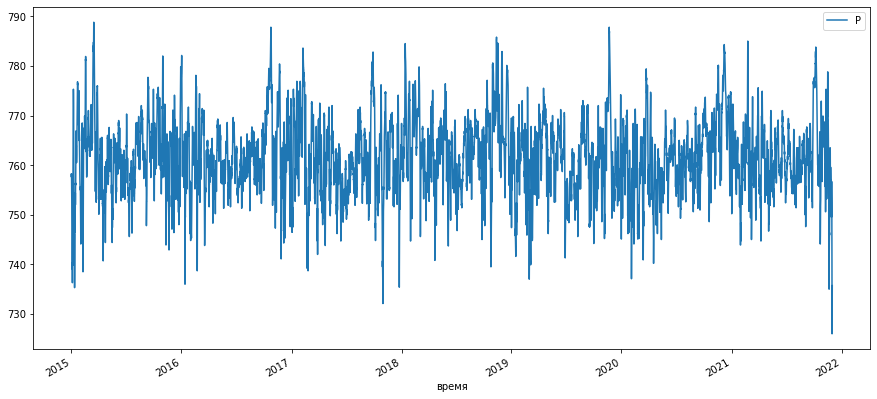

In [49]:
dtp_join.plot(kind='line', x='время', y='P', figsize=(15,7))

Все количественные параметры погоды были проверены на аномальность распределения путем построения графиков типа "Зависимость параметра от времени". За счет этого были приведены к количественным значениям параметры облачности, горизонтальной дальности видимости. В данных о погоде выявлена следующая аномалия: параметр 'Pa' - Барическая тенденция - перестали замерять в январе 2017 года, хоть и это вычисляемая величина. Данный момент необходимо учесть при дальнейшем анализе.

In [50]:
dtp_join.groupby('WW').count()['properties.id'].head(50)

WW
                                                                                                                                        42818
Видна молния, грома не слышно.                                                                                                              5
Гроза (с осадками или без них).                                                                                                            61
Гроза слабая или умеренная без града, но с дождем и/или снегом в срок наблюдения.                                                         178
Гроза, но без осадков, в срок наблюдения.                                                                                                  34
Дождь (незамерзающий) неливневый.                                                                                                         417
Дождь замерзающий слабый.                                                                                                                  17
Дож

## Выбор метода анализа ДТП
Основная проблема, возникшая при планировании анализа - а какая аварийность на дороге большая? Если в условный момент при условных -15 градусах и ледяном дожде произошло 100 ДТП то это много или мало? А в сухой солнечный день произошло 200 ДТП, это много или мало? 
В качестве первой гипотезы было выдвинуто следующее - При одинаковых погодных условиях количесвтво ДТП растет пропорционально трафику на дорогах. Так ли это? Проверим. Укрупненно, сгруппируем по дельтам температуры в 5 градусов, 

In [108]:
dtp_join.rename(columns= {
    'geometry.type':'geometry_type',
 'geometry.coordinates':'coordinates',
 'properties.id':'id',
 'properties.tags':'tags',
 'properties.light':'light',
 'properties.point.lat':'lat',
 'properties.point.long':'long',
 'properties.nearby':'nearby',
 'properties.region':'region',
 'properties.scheme':'scheme',
 'properties.address':'address',
 'properties.weather':'weather',
 'properties.category':'category',
 'properties.datetime':'datetime',
 'properties.severity':'severity',
 'properties.vehicles':'vehicles',
 'properties.dead_count':'dead_count',
 'properties.participants':'participants',
 'properties.injured_count':'injured_count',
 'properties.parent_region':'parent_region',
 'properties.road_conditions':'road_conditions',
 'properties.participants_count':'participants_count',
 'properties.participant_categories':'participant_categories'}, inplace=True)
dtp_join.head(2)

,geometry_type,coordinates,id,tags,light,lat,long,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories,year,traffic,...,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,Point,"[37.770245, 55.667499]",2575117,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",55.667499,37.770245,[Автостоянка (не отделённая от проезжей части)...,Люблино,910,"г Москва, ул Верхние Поля, 39",Я с н о,Наезд на стоящее ТС,2021-05-21,Легкий,"[{'year': 1993, 'brand': 'TOYOTA', 'color': 'С...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",2,Москва,Сухое,3,"[Пешеходы, Все участники]",2021,0.05,...,-0.6,85.0,"Ветер, дующий с юго-востока",1.0,NaN,NaN,30.0,,NaN,NaN,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",30.0,"2500 или более, или облаков нет.","Высококучевые просвечивающие, расположенные на...","Перистых, перисто-кучевых или перисто-слоистых...",NaN,11.2,NaN,NaN,NaN,NaN,NaN,NaN
1,Point,"[37.553995, 55.669411]",2575131,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено",55.669411,37.553995,[Крупный торговый объект (являющийся объектом ...,Черемушки,960,"г Москва, ул Профсоюзная, 56",Я с н о,Падение пассажира,2021-05-15,Легкий,"[{'year': 2018, 'brand': 'FORD', 'color': 'Мно...",0,[],1,Москва,Сухое,2,[Все участники],2021,0.32,...,NaN,71.0,"Ветер, дующий с востока",1.0,NaN,NaN,100.0,,NaN,NaN,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.",100.0,600-1000,NaN,NaN,10.0,11.2,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
(dtp_join.drop(axis=1, 
                     labels=['tags',
                             'coordinates',
                             'nearby',
                             'participants',
                             'vehicles', 
                             'participant_categories'])
              .to_csv('dtp_join_1.csv'))
#dtp_join[0:21000].to_json('dtp_join_1.json')
#dtp_join[21000:42000].to_json('dtp_join_2.json')
#dtp_join[42000:].to_json('dtp_join_3.json')

In [210]:
#dtp_join.drop(axis=1, labels=['tags','coordinates','nearby','participants','vehicles', 'participant_categories']).head(2
#concat_data = pd.json_normalize(dtp_part.head(1)[0])
concat_data = pd.DataFrame(columns=['role','gender','violations','health_status','properties.id'])
def js_join(rows):
    global concat_data
    for i in range(rows['part_count']):
        concat_data = (pd.concat([concat_data, pd.json_normalize(rows[i]).join(pd.DataFrame(data={'propetties.id': [rows['properties.id']]}))]))
    return()
dtp_part.apply(lambda x: js_join(x), axis=1)


0        None
1        None
2        None
3        None
4        None
         ... 
62563    None
62564    None
62565    None
62566    None
62567    None
Length: 62568, dtype: object

In [214]:
concat_data.to_csv('people_in_dtp.csv')